# Data Augmentation 

### Notebook designed to analyze a dataSet and generate a new, balanced one. Save images after applying transformations with fastAI v2.

## Data Augmentation

In [3]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.9.2 (default, Mar 16 2021, 09:09:15) 
[GCC 7.5.0]
Pytorch: 1.7.1
Fastai: 2.2.7


In [4]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from torchvision.utils import save_image
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import PIL 
import os

## Create Augmented Folder and Load Trainset/Testset


In [50]:
pathToDataSet = '/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/'
#pathToDataSet = "./dataset_v1/"
pathToAugmentedFolder = pathToDataSet + 'augmentedDataset/'
pathToAugmentedFolderDone = pathToAugmentedFolder + 'done/'
pathToAugmentedFolderGT = pathToAugmentedFolder + 'gt/'
path_anno = pathToDataSet + 'gt/'
path_img = pathToDataSet + 'done/'
get_y_fn = lambda x : path_anno + f'{x.stem}_GT.png'
get_y_fn_augmented = lambda x : pathToAugmentedFolderGT + f'{x.stem}_GT.png'


fnames = get_image_files(path_img)
print(len(fnames))

508


In [7]:
# get training and testing files from Multi Label Stratified Split 

with open('var/trainFilenames.pkl', 'rb') as f:
  trainFiles = pickle.load(f) #trainFiles is an array with image names that should be in the training phase
with open('var/testFilenames.pkl', 'rb') as f:
  testFiles = pickle.load(f)

train_fnames = []
test_fnames = []
for i in range(0, len(fnames)):
    if fnames[i].name in trainFiles:
        train_fnames.append(fnames[i])
    elif fnames[i].name in testFiles:
        test_fnames.append(fnames[i])

len(train_fnames), len(test_fnames)

(362, 107)

In [8]:
# create folder for augmented data
try: 
    os.mkdir(pathToAugmentedFolder)
    print('Created Augmented Folder')
except OSError as error:
    print(error)

try: 
    os.mkdir(pathToAugmentedFolderDone)
    print('Created Augmented Folder Done')
except OSError as error:
    print(error)

try: 
    os.mkdir(pathToAugmentedFolderGT)
    print('Created Augmented Folder GT')
except OSError as error:
    print(error)

Created Augmented Folder
Created Augmented Folder Done
Created Augmented Folder GT


In [9]:
# copy trainset/testset and their gts to this augmented folder. Later in the training, we should split again the test images using the pickle file

from shutil import copyfile

for i in range(0, len(train_fnames)):
    copyfile(str(train_fnames[i]), pathToAugmentedFolderDone + train_fnames[i].name)
    copyfile(get_y_fn(train_fnames[i]), pathToAugmentedFolderGT + train_fnames[i].stem + "_GT.png")

for i in range(0, len(test_fnames)):
    copyfile(str(test_fnames[i]), pathToAugmentedFolderDone + test_fnames[i].name)
    copyfile(get_y_fn(test_fnames[i]), pathToAugmentedFolderGT + test_fnames[i].stem + "_GT.png")

In [10]:
# continue the algorithm only for the training images (augmentation should not be done in testset)

fnames = train_fnames
print(len(fnames))

362


## Generate DataSet Histogram

In [41]:
totalArray = []

for i in range(0,len(fnames)):
    img = Image.open(get_y_fn(fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

print('Array Generated')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/gt/102_Augmented_0_GT.png'

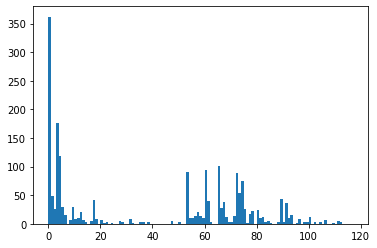

In [12]:
codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionario = {}


for code, contagem in zip(codes, hist[0]):
    dicionario[code] = int(contagem)

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=True)} #sort



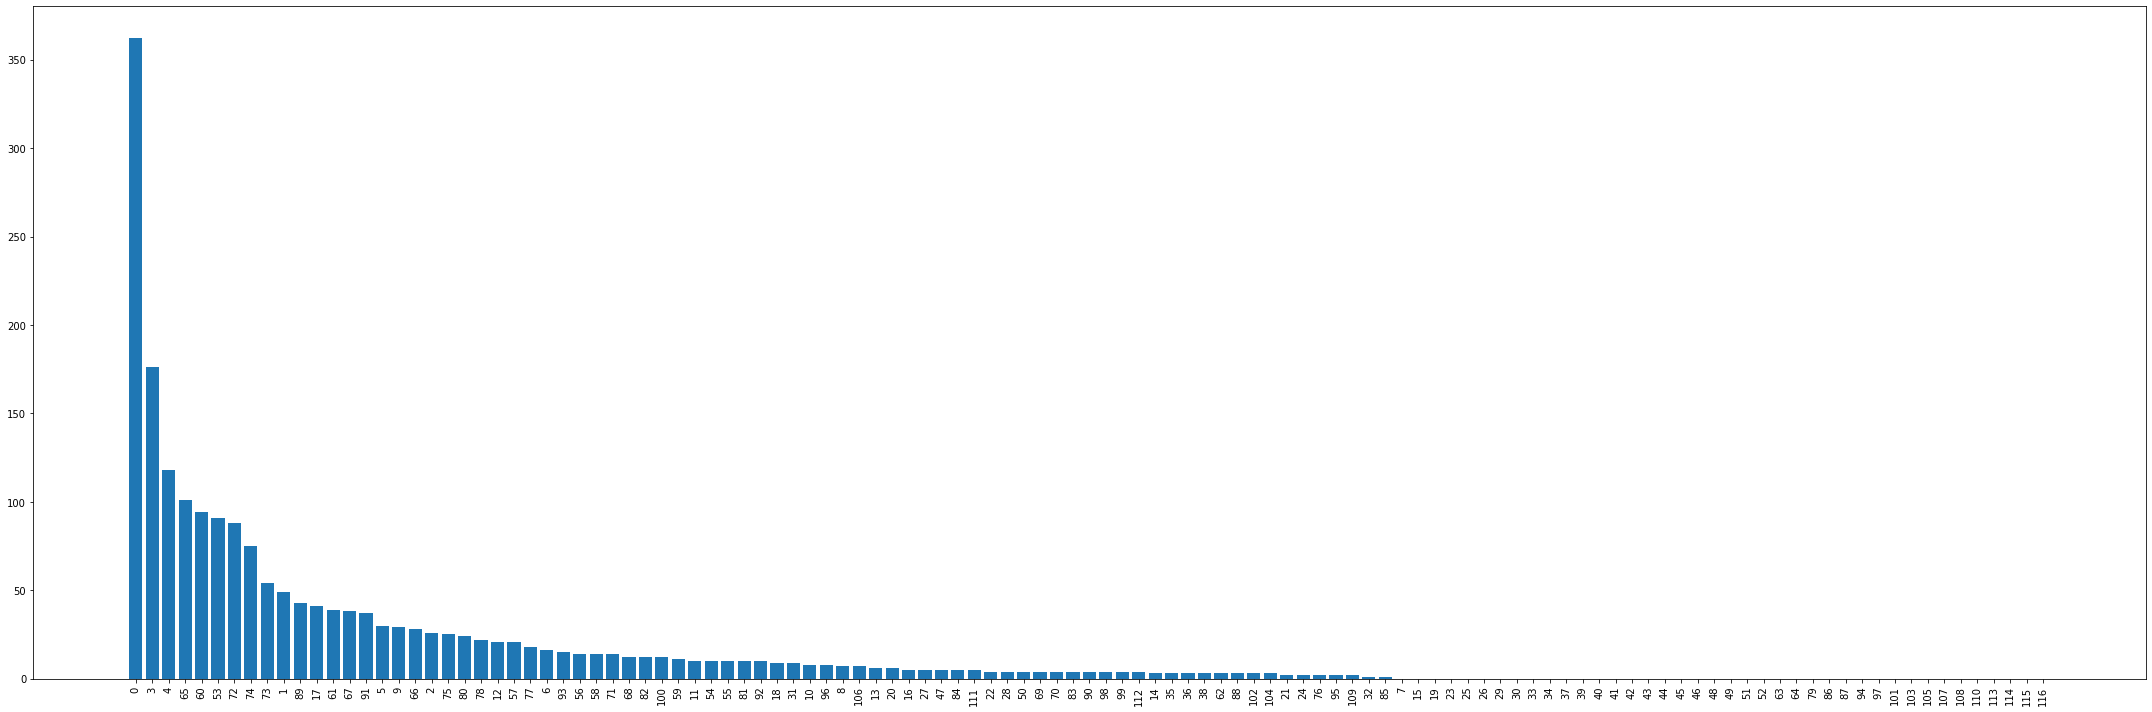

In [13]:
plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionario.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
#The idx 1 is related to the class that appears the most, except for the backGround class 0.

print('Class that most appears >>> ', list(dicionario.items())[1][0])
print('Appears >>> ', list(dicionario.items())[1][1], ' times')

dataBaseImageNumberThreshold =  list(dicionario.items())[1][1]

Class that most appears >>>  3
Appears >>>  176  times


## Augment images based on class that most appears

In [51]:
# get all ground truth images and label ids of each sample

allGTs = []
idsInGTs = []
for idx in range(0,len(fnames)):
    img = Image.open(get_y_fn(fnames[idx]))
    arr = np.asarray(img)
    idsInGTs.append(list(np.unique(arr,return_counts=False)))
    allGTs.append(arr)

In [52]:
def getImagesByClass(classId):
    imagesWithClass = []

    for i in range(0, len(fnames)):
        arr = allGTs[i]
        idsInGT = idsInGTs[i]
        if int(classId) in idsInGT:
            imagesWithClass.append(fnames[i])

    return imagesWithClass

<ipython-input-53-65e6c6164177>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


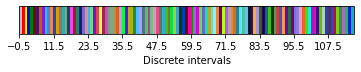

In [53]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

In [54]:
def myTransforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10., min_zoom=1., max_zoom=1.1,
                   max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None,
                   mode='bilinear', pad_mode=PadMode.Reflection, align_corners=True, batch=False, min_scale=1.):
    "Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms."
    res,tkw = [],dict(size=size if min_scale==1. else None, mode=mode, pad_mode=pad_mode, batch=batch, align_corners=align_corners)
    max_rotate,max_lighting,max_warp = array([max_rotate,max_lighting,max_warp])*mult
    if do_flip: res.append(Dihedral(p=1, **tkw) if flip_vert else Flip(p=1, **tkw))
    if max_warp > 0:   res.append(Warp(magnitude=max_warp, p=p_affine, **tkw))
    if max_rotate: res.append(Rotate(max_deg=max_rotate, p=p_affine, **tkw))
    if min_zoom<1 or max_zoom>1: res.append(Zoom(min_zoom=min_zoom, max_zoom=max_zoom, p=p_affine, **tkw))
    if max_lighting:
        res.append(Brightness(max_lighting=max_lighting, p=p_lighting, batch=batch))
        res.append(Contrast(max_lighting=max_lighting, p=p_lighting, batch=batch))
    return setup_aug_tfms(res)

In [55]:
def augmentImages(imagesArray, numberOfAugmentation, classID):

    tfms = myTransforms(flip_vert=True, max_rotate=20., min_zoom=0.8, max_zoom=1.2, max_lighting=0.5, max_warp=0.2, p_affine=0.9, p_lighting=0.9)
    bs = 1
    numberOfGeneratedImages = 0


    dataloaders = SegmentationDataLoaders.from_label_func(path_img, bs=bs,
    fnames = imagesArray,
    num_workers = 1, 
    label_func = get_y_fn,                                     
    codes = codes,   
    valid_pct=0.0,
    shuffle=False,
    seed=None,                
    batch_tfms=tfms)

    dataloaders.vocab = codes
    for i in range(numberOfAugmentation):
        if(numberOfGeneratedImages == numberOfAugmentation):
            break

        for idx, batch in enumerate(dataloaders.train):
    
            augmentedImage = batch[0].squeeze().permute(1,2,0).cpu().numpy()
            augmentedGroundTruth = batch[1].squeeze().cpu().numpy()

            plt.imsave(pathToAugmentedFolderDone + classID + '_Augmented_' + str(numberOfGeneratedImages) + '.jpg', augmentedImage)
            Image.fromarray(np.uint8(augmentedGroundTruth), 'L').save(pathToAugmentedFolderGT + classID + '_Augmented_' + str(numberOfGeneratedImages) + '_GT.png')
            

            numberOfGeneratedImages = numberOfGeneratedImages + 1
            
            if(numberOfGeneratedImages == numberOfAugmentation):
                break

        


In [58]:
#dataBaseImageNumberThreshold = 4 ############# remover essa linha do codigo depois que testar o resultado!!!!!! ############

for key,value in list(dicionario.items()):
    
    numberOfAppearences = value

    if numberOfAppearences > 0 and numberOfAppearences < dataBaseImageNumberThreshold:

        numberOfImagesNeeded = dataBaseImageNumberThreshold - numberOfAppearences
        imagesWithClass = getImagesByClass(key)

        if(numberOfAppearences != 0):
            augmentImages(imagesWithClass, numberOfImagesNeeded, key)
        

## Check augmentation results

In [43]:
fnames = get_image_files(pathToAugmentedFolderDone)
print(len(fnames))

493


In [44]:
totalArray = []

for i in range(0,len(fnames)):
    img = Image.open(get_y_fn_augmented(fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

print('Array Generated')

Array Generated


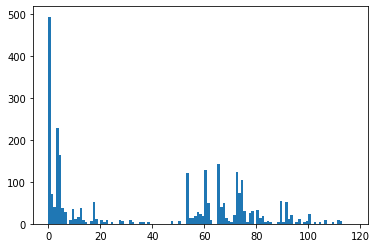

In [46]:
codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionario = {}


for code, contagem in zip(codes, hist[0]):
    dicionario[code] = int(contagem)

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=True)} #sort

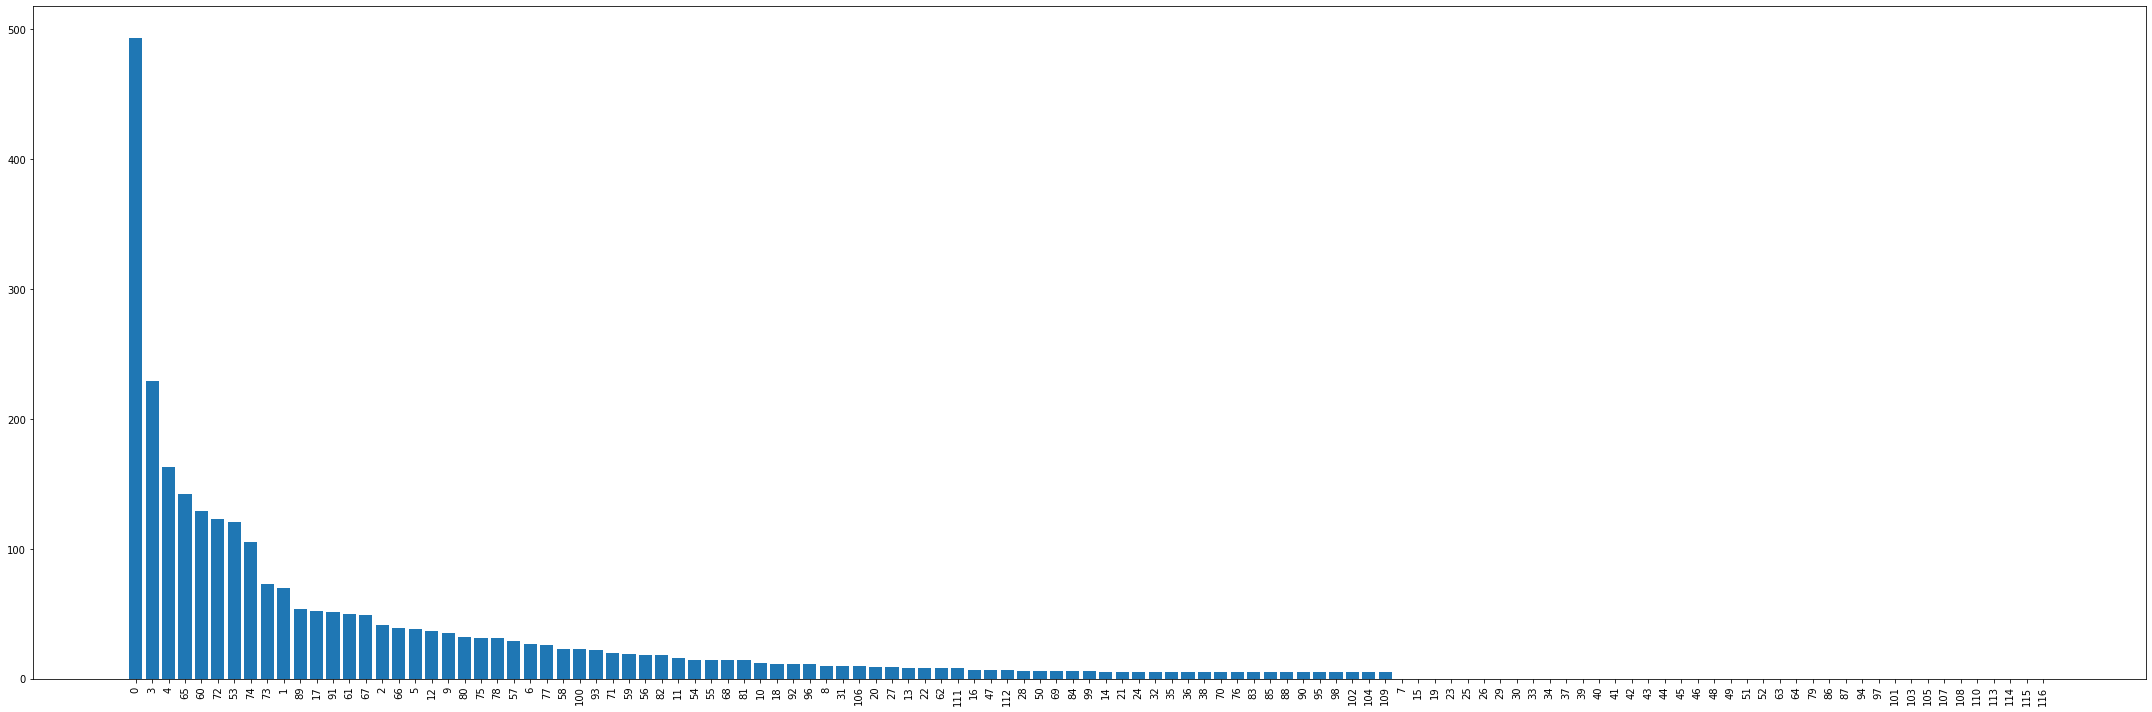

In [48]:
plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionario.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()